# Analysis of the single assessment


In [34]:
import os
import numpy as np
import pandas as pd   # module to work with data in DataFrames.
import seaborn as sns  # module to plot DataFrames in an easy way
import matplotlib.pyplot as plt
from pathlib import Path
import scipy.constants as sc

In [35]:
# seaborn comes with default presets (called 'contents') for figure's aesthetics, 
# such as the font size, figure size etc.

sns.set_context('paper') # try: 'talk', 'poster', 'notebook'
sns.set_theme(style="ticks", palette="pastel")

# Set global color scheme for historic and modern images.
sns_palette_historic = ["m"]
sns_palette_modern = ["g"]

# Plot size:
sns_plot_size = (12*sc.golden_ratio, 12)
sns_ylim = (-0.5, 1)

## Get the result files

In [36]:
# Get current result files.
result_dir = Path('../nines/results').absolute()
result_file_names = os.listdir(result_dir)
result_file_names = list(filter(lambda name: str.startswith(name, 'result'), result_file_names))

single_result_files_paths = []
for name in result_file_names:
    single_result_files_paths.append(result_dir / name)

print(f"Number observer: {len(single_result_files_paths)}")

Number observer: 23


Write result files to dataframe.

In [37]:
df = pd.DataFrame()
for index, path in enumerate(single_result_files_paths):
    df_tmp = pd.read_csv(path)
    df_tmp['observer'] = index
    df = pd.concat((df, df_tmp))

df.columns = ['test_image', '0', '1', '2', '3', '4', '5', '6', '7', '8', 'choosen', 'observer']


## Clean up of image names

In [38]:
df['test_image'] = [s.split('_')[0] for s in df['test_image'].tolist()]
df = df.sort_values(by='test_image', ascending=True, key=lambda col: [int(img[1:]) for img in col])

Some observers may have seen more images than planned for.
These images are removed.

In [39]:
list_of_used_images = [f"H{index}" for index in range(30)]
list_of_used_images += [f"I{index:02d}" for index in [1, 3, 4, 6, 7, 8, 12, 13, 14, 15 ,16, 20, 21, 22, 23]]
assert len(list_of_used_images) == 30 + 15

In [40]:
df = df[df["test_image"].isin(list_of_used_images)]

## Sanity checks
We expect 30 historic and 15 modern images used during tests.
Each result file  from each observer shall be 30 + 15 images long.

In [41]:
# sanity checks: how many groups do you expect per categorical variable?
assert len(df['test_image'].unique()) == 30 + 15

# Check number of observers.
assert len(df['observer'].unique()) == len(result_file_names)

# Check length of result from each observer.
for observer_id in df['observer'].unique():
    assert len(df[df['observer'] == observer_id]) == 30 + 15
    assert len(df[df['observer'] == observer_id]['test_image'].unique()) == 30 + 15

## Normalise chroma values

In [42]:
df["choosen"] = [(entry[0] / entry[1]) - 1 / entry[1] for entry in list(zip(df["choosen"].tolist(), df["8"].tolist()))]

In [43]:
df

,test_image,0,1,2,3,4,5,6,7,8,choosen,observer
18,H0,0.6,1.0,1.42,1.84,2.27,2.70,3.14,3.58,4.03,-0.099256,17
18,H0,0.6,1.0,1.42,1.84,2.27,2.70,3.14,3.58,4.03,0.640199,20
44,H0,0.6,1.0,1.42,1.84,2.27,2.70,3.14,3.58,4.03,0.531017,21
33,H0,0.6,1.0,1.42,1.84,2.27,2.70,3.14,3.58,4.03,0.640199,1
3,H0,0.6,1.0,1.42,1.84,2.27,2.70,3.14,3.58,4.03,-0.099256,6
...,...,...,...,...,...,...,...,...,...,...,...,...
34,H29,0.6,1.0,1.36,1.72,2.06,2.39,2.72,3.03,3.34,0.107784,14
0,H29,0.6,1.0,1.36,1.72,2.06,2.39,2.72,3.03,3.34,0.607784,22
5,H29,0.6,1.0,1.36,1.72,2.06,2.39,2.72,3.03,3.34,0.607784,3
1,H29,0.6,1.0,1.36,1.72,2.06,2.39,2.72,3.03,3.34,0.514970,8


In [44]:
max_factor = np.ceil(max(df[[str(i) for i in range(9)]].max(axis=0)))


### Devide dataframe into historic and modern images
And verify result.

In [45]:
df_historic = df[df['test_image'].str.startswith('H')]
df_modern = df[df['test_image'].str.startswith('I')]

assert len(df_historic['test_image'].unique()) == 30
assert len(df_modern['test_image'].unique()) == 15

### Historic plots

Boxplot

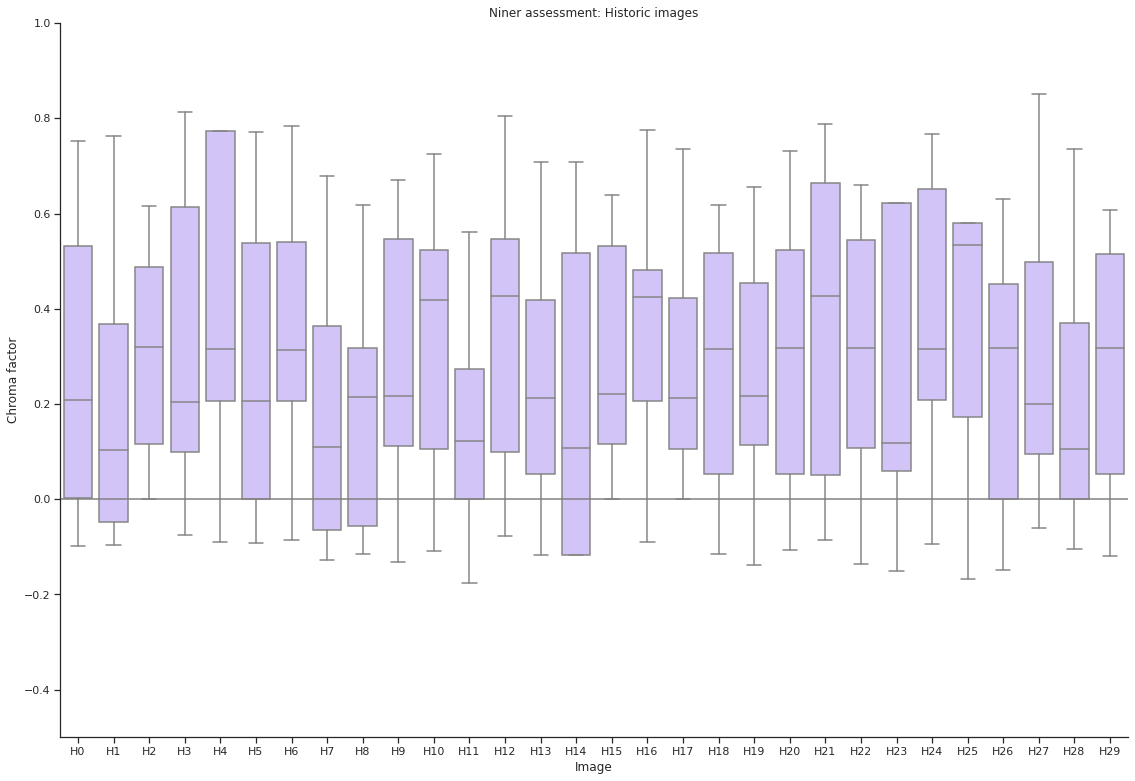

In [46]:
g = sns.catplot(
    x='test_image',
    y='choosen',
    data=df_historic,
    kind='box',
    ci='sd',
    #color='#e34a33')
    palette=sns_palette_historic
)

g.axes[0][0].axhline(0.0, color='gray')

g.fig.set_size_inches(sns_plot_size)

g.set(ylim = sns_ylim)

g.set_axis_labels("Image", "Chroma factor")
g.set(title="Niner assessment: Historic images")

sns.despine()

### Modern plots

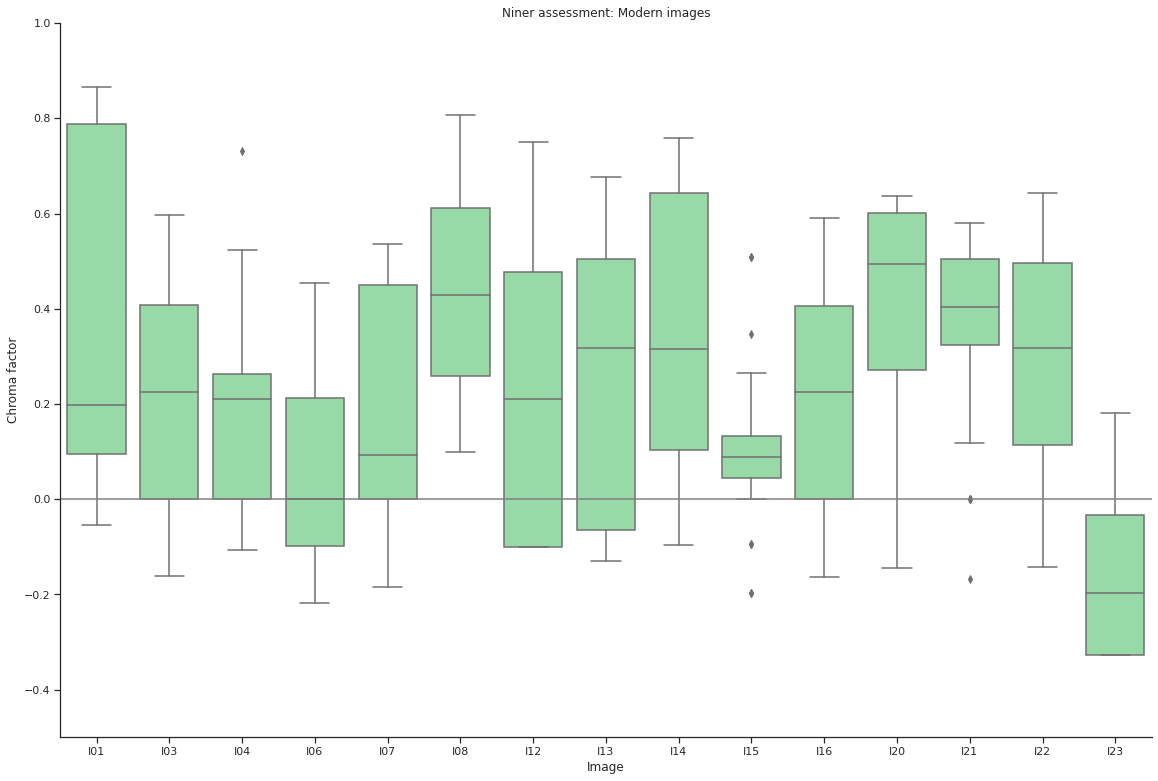

In [47]:
g = sns.catplot(
    x='test_image',
    y='choosen',
    data=df_modern,
    kind='box',
    ci='sd', 
    palette=sns_palette_modern
)
g.axes[0][0].axhline(0.0, color='gray')

g.fig.set_size_inches(sns_plot_size)

g.set(ylim = sns_ylim)

g.set_axis_labels("Image", "Chroma factor")
g.set(title="Niner assessment: Modern images")
sns.despine()

# Plots for both image groups

In [48]:
means = []
for img in df_historic["test_image"].unique():
    means.append((img, "H", np.mean(df_historic[df_historic["test_image"] == img])["choosen"]))

for img in df_modern["test_image"].unique():
    means.append((img, "I", np.mean(df_modern[df_modern["test_image"] == img])["choosen"]))
    
df_mean = pd.DataFrame(means)
df_mean.columns = ["test_image", "type", "mean"]
df_mean

,test_image,type,mean
0,H0,H,0.274247
1,H1,H,0.150414
2,H2,H,0.292308
3,H3,H,0.291694
4,H4,H,0.427191
5,H5,H,0.270476
6,H6,H,0.324769
7,H7,H,0.174331
8,H8,H,0.154161
9,H9,H,0.287614


Boxplot overall modern and historic images.

[[Text(0, 0, 'Historic'), Text(1, 0, 'Modern')]]

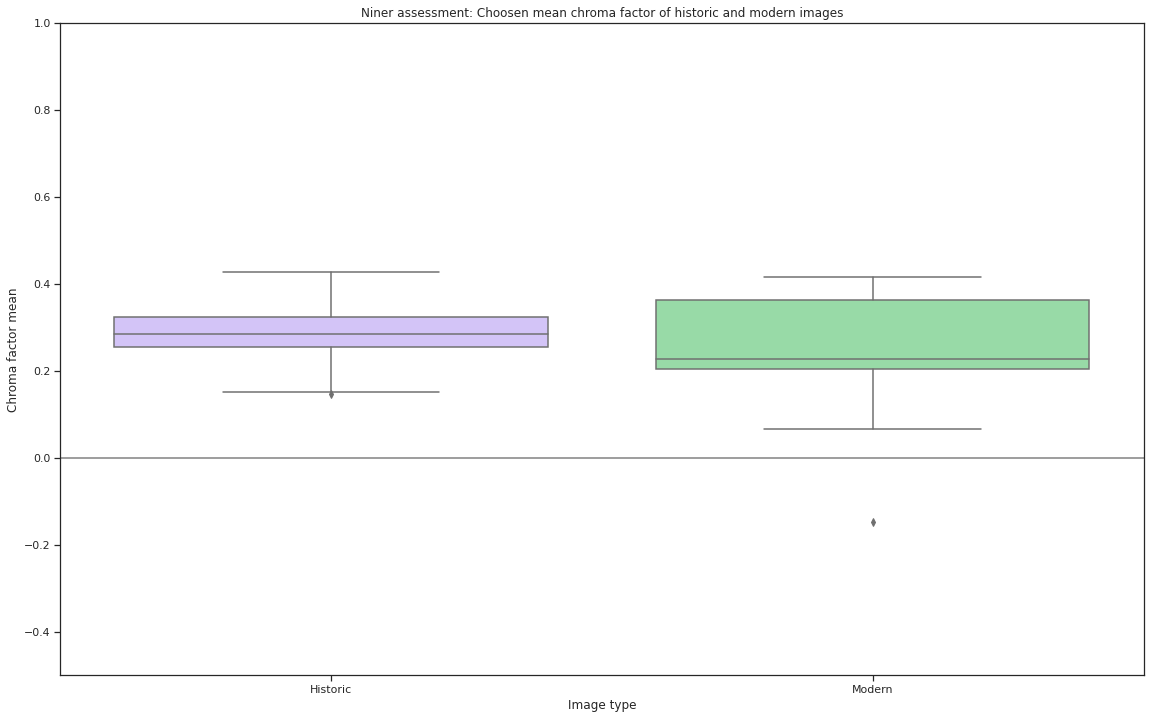

In [49]:
g = sns.boxplot(
    x="type",
    y="mean",
    palette=[sns_palette_historic[0], sns_palette_modern[0]],
    data=df_mean
)
g.axhline(0.0, color='gray')

g.set(title="Niner assessment: Choosen mean chroma factor of historic and modern images")
g.figure.set_size_inches(sns_plot_size)
g.set(ylim = sns_ylim)
g.set_xlabel("Image type")
g.set_ylabel("Chroma factor mean")
g.set(xticklabels=["Historic", "Modern"])